In [ ]:
# ✅ Install necessary libraries (run in Colab if needed)
!pip install scikit-learn pandas matplotlib

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00



Starting sample 1 at 19:35:49
Iteration 1/100

<ipython-input-7-d7cba6f2e7c6>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.dropna(thresh=len(df)*0.7, axis=1).fillna(method='ffill').dropna()


Iteration 100/100Completed sample 1 with accuracy: 0.8015

Starting sample 2 at 19:41:21
Iteration 100/100Completed sample 2 with accuracy: 0.7836

Starting sample 3 at 19:46:48
Iteration 100/100Completed sample 3 with accuracy: 0.7903

Starting sample 4 at 19:52:45
Iteration 100/100Completed sample 4 with accuracy: 0.7861

Starting sample 5 at 19:58:01
Iteration 100/100Completed sample 5 with accuracy: 0.7938

Starting sample 6 at 20:03:59
Iteration 100/100Completed sample 6 with accuracy: 0.8019

Starting sample 7 at 20:09:20
Iteration 100/100Completed sample 7 with accuracy: 0.7928

Starting sample 8 at 20:15:05
Iteration 100/100Completed sample 8 with accuracy: 0.7959

Starting sample 9 at 20:20:57
Iteration 100/100Completed sample 9 with accuracy: 0.7618

Starting sample 10 at 20:26:26
Iteration 100/100Completed sample 10 with accuracy: 0.8005

Table 1: Comparative performance of Optimized-SVM with different samples
Sample #  Best Accuracy  Best SVM Parameters (Kernel, Nu, Gamma) 

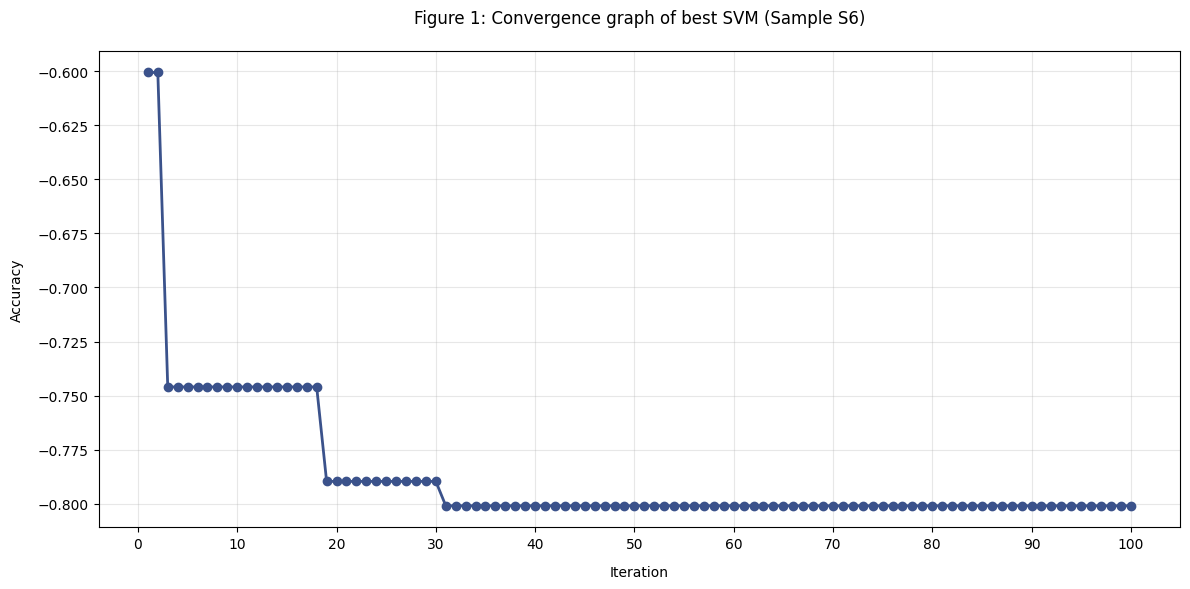

In [7]:
from skopt.callbacks import DeadlineStopper, DeltaYStopper
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC  # Changed to ν-SVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from skopt import gp_minimize
from skopt.plots import plot_convergence
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import warnings

# Custom callback to print progress
def print_progress(res):
    print(f"\rIteration {len(res.x_iters)}/{100}", end='', flush=True)

# Load and preprocess data
df = pd.read_csv("/content/AirQualityUCI.csv", delimiter=';', decimal=',', na_values=['-200'])

# 1. Drop the last empty column and clean data
df = df.drop(df.columns[-1], axis=1)
df['Time'] = df['Time'].str.replace('.', ':')
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df.drop(['Date', 'Time'], axis=1)
df = df.dropna(thresh=len(df)*0.7, axis=1).fillna(method='ffill').dropna()

# 2. Create target classes with proper class distribution
bins = [0, 1, 2, 3, float('inf')]
labels = ['Good', 'Moderate', 'Poor', 'Very Poor']
df['AirQuality'] = pd.cut(df['CO(GT)'], bins=bins, labels=labels)

# 3. Prepare features and target
X = df.drop(['DateTime', 'CO(GT)', 'AirQuality'], axis=1)
for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].str.replace(',', '.').astype(float)
y = df['AirQuality']

# 4. Standardize and encode
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Verify data integrity
assert not np.isnan(X_scaled).any(), "Data contains NaN values!"
assert len(np.unique(y_encoded)) > 2, "Not a multi-class problem!"

# Prepare results table
results = []
best_res = None
best_accuracy = 0

for sample in range(1, 11):
    print(f"\nStarting sample {sample} at {datetime.now().strftime('%H:%M:%S')}")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.3, random_state=sample
    )

    def optimize_svm(params):
        kernel, nu, gamma = params  # Changed to nu parameter

        model = NuSVC(
            kernel=kernel,
            nu=nu,  # ν parameter (0 < nu <= 1)
            gamma=gamma,
            max_iter=1000,
            cache_size=1000,
            tol=1e-3,
            random_state=42
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            try:
                model.fit(X_train, y_train)
                return -accuracy_score(y_test, model.predict(X_test))
            except:
                return 1000

    # Updated parameter space for ν-SVM
    space = [
        ['linear', 'rbf', 'poly'],  # Kernel types
        (0.01, 0.99),  # ν range (0 < nu <= 1)
        ['scale', 'auto']  # Gamma options
    ]

    res = gp_minimize(
        optimize_svm,
        space,
        n_calls=100,
        random_state=sample,
        callback=[print_progress, DeadlineStopper(60*15)],  # 15 min timeout
        n_initial_points=20
    )

    # Final evaluation
    final_model = NuSVC(
        kernel=res.x[0],
        nu=res.x[1],
        gamma=res.x[2],
        random_state=42
    )
    final_model.fit(X_train, y_train)
    final_accuracy = accuracy_score(y_test, final_model.predict(X_test))

    # Store results
    results.append({
        'Sample': f'S{sample}',
        'Best Accuracy': round(final_accuracy, 4),
        'Parameters': {
            'Kernel': res.x[0],
            'Nu': round(res.x[1], 4),
            'Gamma': res.x[2]
        }
    })

    # Track best sample for convergence plot
    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_res = res
        best_sample_num = sample

    print(f"Completed sample {sample} with accuracy: {final_accuracy:.4f}")

# Generate formatted results table
print("\n" + "="*80)
print("Table 1: Comparative performance of Optimized-SVM with different samples")
print("="*80)
print(f"{'Sample #':<10}{'Best Accuracy':<15}{'Best SVM Parameters (Kernel, Nu, Gamma)':<50}")
print("-"*80)
for res in results:
    params = res['Parameters']
    print(f"{res['Sample']:<10}{res['Best Accuracy']:<15.4f}{params['Kernel']}, {params['Nu']}, {params['Gamma']}")

# Plot convergence for best sample
plt.figure(figsize=(12, 6))
plot_convergence(best_res)
plt.title(f'Figure 1: Convergence graph of best SVM (Sample S{best_sample_num})', pad=20)
plt.xlabel('Iteration', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 101, 10))
plt.tight_layout()
plt.savefig('convergence_graph.png', dpi=300)
plt.show()